# 参考链接
主成分分析法 http://c.biancheng.net/view/1951.html
关于sklearn.preprocessing中scale和StandardScaler的使用 https://blog.csdn.net/dengdengma520/article/details/79629186
机器学习—保存模型、加载模型—Joblib https://blog.csdn.net/weixin_45252110/article/details/98883571
Scipy教程 - 统计函数库scipy.stats https://blog.csdn.net/pipisorry/article/details/49515215
word2vec的应用----使用gensim来训练模型 https://blog.csdn.net/qq_35273499/article/details/79098689
scipy.stats的用法——常见的分布和函数 https://blog.csdn.net/baby_superman/article/details/83749803

In [1]:
import numpy as np
import sys
import re
import codecs # 解码库
import os
import jieba
import gensim,logging
from gensim.models import word2vec
from sklearn.model_selection import train_test_split
# from sklearn.externals import joblib # 保存模型、加载模型
import joblib
from sklearn.preprocessing import scale # 直接将给定数据进行标准化。=> 均值为零，标准差为1
from sklearn.svm import SVC # Support Vector Classification 就是支持向量机用于分类
from sklearn.decomposition import PCA # Principal Component Analysis 主成分分析
from sklearn.metrics import f1_score 
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score as auc
from scipy import stats # 统计函数库
from scipy.stats import ks_2samp
from keras.models import Sequential 
from keras.layers import Dense,Dropout, Activation 
from keras.optimizers import SGD
from keras.layers.embeddings import Embedding
from keras.layers.recurrent import LSTM
import matplotlib.pyplot as plt
import sklearn

# 加载W2V模型

In [2]:
W2Vmodel = word2vec.Word2Vec.load("W2Vmodel\CommentsW2V.model")

In [3]:
def getWordVecs(wordList):
    vecs = []
    for word in wordList:
        word = word.replace("\n","")
        try:
            vecs.append(W2Vmodel[word])
        except KeyError:
            continue
    return np.array(vecs,dtype="float")

def buildWordVec(filename):
    posInput = []
    with open(filename,"r",encoding="utf8") as textfile:
        for line in textfile:
            if not line.strip():
                continue
            line = line.split(" ")[2:]
            line = line[:-1]
            resultList = getWordVecs(line)
            if len(resultList) > 0:
                resultArray = sum(np.array(resultList))/len(resultList)
                posInput.append(resultArray)
    return posInput

In [4]:
posInput = buildWordVec("dataset\TrainPos.txt")
negInput = buildWordVec("dataset\TrainNeg.txt")

D:\app\anaconda\envs\pls\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


In [5]:
y = np.concatenate((np.ones(len(posInput)),np.zeros(len(negInput))))
X = posInput + negInput
#标准化
X = scale(X) 
# PCA降维成100维
X_reduced = PCA(n_components=100).fit_transform(X)

In [32]:
# 训练集和测试集
X_reduced_train,X_reduced_test,y_reduced_train,y_reduced_test = train_test_split(X_reduced,y,test_size=0.4,random_state=1)
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.4,random_state=1)

### 有两个PCA类的成员值得关注。
第一个是explained_variance_，它代表降维后的各主成分的方差值。方差值越大，则说明越是重要的主成分。
第二个是explained_variance_ratio_，它代表降维后的各主成分的方差值占总方差值的比例，这个比例越大，则越是重要的主成分。

plt.axes 四个参数的话，
前两个指的是相对于坐标原点的位置，
后两个指的是坐标轴的长/宽度

### 画图分析

Text(0, 0.5, 'explained_variance_')

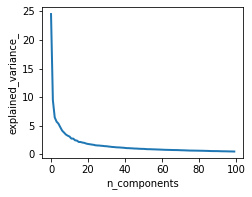

In [8]:
pca=PCA(n_components=100)  
pca.fit(X) 
plt.figure(1, figsize=(4, 3)) 
plt.clf() 
plt.axes([.2, .2, .7, .7]) 
plt.plot(pca.explained_variance_, linewidth=2) 
plt.axis('tight') 
plt.xlabel('n_components') 
plt.ylabel('explained_variance_') 

通过图，可以很直观的看出，当维度是100的时候
每一个维度代表的重要程度都差不多
说明每一个维度都是不可或缺的，达到了数据降维的目的。

In [9]:
# 所以使用 n_components = 100
X_reduced = PCA(n_components = 100).fit_transform(X)

# 2.3.1 SVM (RBF) + PCA
SVM (RBF)分类表现更为宽松，且使用PCA降维后的模型表现有明显提升，

高斯核和多项式核干的事情截然不同的，如果对于样本数量少，特征多的数据集，高斯核相当于对样本降维；

高斯核的任务：找到更有利分类任务的新的空间。

高斯核本质是在衡量样本和样本之间的“相似度”，在一个刻画“相似度”的空间中，

让同类样本更好的聚在一起，进而线性可分。

C越大，对误分类惩罚越大，训练集准确率高，泛化能力弱

C越小，反之

In [10]:
clf = SVC(C = 2, probability = True) 
clf.fit(X_reduced_train, y_reduced_train) 
print ('Test Accuracy: %.2f'% clf.score(X_reduced_test, y_reduced_test) )

Test Accuracy: 0.79


KS用于模型风险区分能力进行评估，KS指标衡量的是好坏样本累计分布之间的差值。好坏样本累计差异越大，KS指标越大，那么模型的风险区分能力越强。

In [16]:
pred_probas = clf.predict_proba(X_reduced_test)[:,1]
# 返回预测属于某标签的概率 
print ("KS value: %f" % ks_2samp(y_reduced_test, pred_probas)[0] )

KS value: 0.534508


AUC = 1，是完美分类器。<br>
AUC = 0.5，跟随机猜测一样（例：丢铜板），模型没有预测价值。<br>
AUC < 0.5，比随机猜测还差；但只要总是反预测而行，就优于随机猜测。

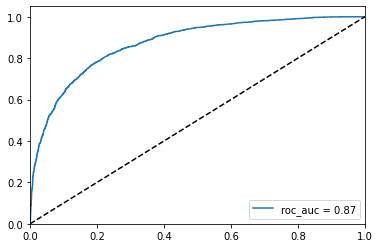

In [13]:
fpr,tpr,_ = roc_curve(y_reduced_test, pred_probas)
roc_auc =  sklearn.metrics.auc(fpr,tpr)
plt.plot(fpr, tpr, label = 'roc_auc = %.2f' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.legend(loc = 'lower right')
plt.show()

auc = 0.87 效果很好

In [92]:
joblib.dump(clf, "outputs/SVC.pkl")

['outputs/SVC.pkl']

### 2.3.2 MLP 多层感知机
MLP相比于SVM (RBF)，分类更为严格，PCA降维后对模型准确率影响不大，misclassified多为正向文本被分类为负向，其实是更容易overfitting，原因是语料过少，其实用神经网络未免有些小题大做。

In [27]:
model = Sequential([
    Dense(512,input_dim=200,kernel_initializer="uniform",activation='tanh'),
    Dropout(0.5),
    Dense(256,activation='relu'),
    Dropout(0.5),
    Dense(128,activation='relu'),
    Dropout(0.5),
    Dense(64,activation='relu'),
    Dropout(0.5),
    Dense(32,activation='relu'),
    Dropout(0.5),
    Dense(1,activation="sigmoid"),
])
model.compile(loss='binary_crossentropy',optimizer="adam",metrics=['accuracy'])

In [28]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_18 (Dense)             (None, 512)               102912    
_________________________________________________________________
dropout_15 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_19 (Dense)             (None, 256)               131328    
_________________________________________________________________
dropout_16 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_20 (Dense)             (None, 128)               32896     
_________________________________________________________________
dropout_17 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_21 (Dense)             (None, 64)               

In [33]:
model.fit(X_train, y_train, epochs = 100, batch_size = 16) 

Epoch 1/100
714/714 [==============================] - 2s 3ms/step - loss: 0.6091 - accuracy: 0.6932
Epoch 2/100
714/714 [==============================] - 2s 3ms/step - loss: 0.5324 - accuracy: 0.7620
Epoch 3/100
714/714 [==============================] - 2s 3ms/step - loss: 0.5067 - accuracy: 0.7795
Epoch 4/100
714/714 [==============================] - 2s 3ms/step - loss: 0.4914 - accuracy: 0.7840
Epoch 5/100
714/714 [==============================] - 2s 3ms/step - loss: 0.4795 - accuracy: 0.7876
Epoch 6/100
714/714 [==============================] - 2s 3ms/step - loss: 0.4748 - accuracy: 0.7911
Epoch 7/100
714/714 [==============================] - 2s 3ms/step - loss: 0.4676 - accuracy: 0.7935
Epoch 8/100
714/714 [==============================] - 2s 3ms/step - loss: 0.4682 - accuracy: 0.7923
Epoch 9/100
714/714 [==============================] - 2s 3ms/step - loss: 0.4601 - accuracy: 0.7991
Epoch 10/100
714/714 [==============================] - 2s 3ms/step - loss: 0.4504 - accura

In [34]:
score = model.evaluate(X_test, y_test, batch_size = 16) 
print ('Test accuracy: ', score[1])

476/476 [==============================] - 1s 1ms/step - loss: 0.9922 - accuracy: 0.7866
Test accuracy:  0.7866438627243042


In [35]:
pred_probas2 = model.predict_proba(X_test)[:,0]
print ("KS value: %f" % ks_2samp(y_test, pred_probas2)[0] )

Instructions for updating:
Please use `model.predict()` instead.
KS value: 0.465229


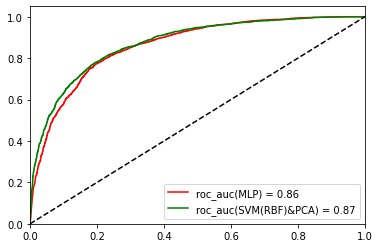

In [36]:
fpr2,tpr2,_ = roc_curve(y_test, pred_probas2) 
roc_auc2 = sklearn.metrics.auc(fpr2,tpr2) 
plt.plot(fpr2, tpr2, label = 'roc_auc(MLP) = %.2f' % roc_auc2, color="red") 
plt.plot(fpr, tpr, label = 'roc_auc(SVM(RBF)&PCA) = %.2f' % roc_auc, color="green")    # SVM above 
plt.plot([0, 1], [0, 1], 'k--') 
plt.xlim([0.0, 1.0]) 
plt.ylim([0.0, 1.05]) 
plt.legend(loc = 'lower right') 
plt.show()

使用MLP和SVM（RBF）&PCA的分类效果差不过。<br>
使用MLP的KS值会低一些，模型的风险区分能力弱一点。

In [94]:
text = "超好看"
seg_list = jieba.cut(text, cut_all=False)
w2cTest = getWordVecs(list(seg_list))
shapedVector = sum(np.array(w2cTest))/len(w2cTest)

print(model.predict(shapedVector.reshape(1,-1)))


[[0.9997544]]


D:\app\anaconda\envs\pls\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


In [96]:
text = "超级无敌好看，太喜欢了"
seg_list = jieba.cut(text, cut_all=False)
w2cTest = getWordVecs(list(seg_list))
shapedVector = sum(np.array(w2cTest))/len(w2cTest)

print(model.predict(shapedVector.reshape(1,-1))[0][0])

0.99455845


D:\app\anaconda\envs\pls\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


In [82]:
text = "垃圾东西，屎一样"
seg_list = jieba.cut(text, cut_all=False)
w2cTest = getWordVecs(list(seg_list))
shapedVector = sum(np.array(w2cTest))/len(w2cTest)

print(model.predict(shapedVector.reshape(1,-1)))

[[7.3054696e-10]]


D:\app\anaconda\envs\pls\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


可以看出，效果很不错

# LSTM

In [83]:
EMBEDDING_SIZE = 128
HIDDEN_LAYER_SIZE = 64
data_dim = 200
timesteps = 1

LSTM_model = Sequential()
LSTM_model.add(LSTM(HIDDEN_LAYER_SIZE,input_shape=(timesteps,data_dim), dropout=0.2, recurrent_dropout=0.2))
LSTM_model.add(Dense(1))
LSTM_model.add(Activation("sigmoid"))
LSTM_model.compile(loss="binary_crossentropy", optimizer="adam",metrics=["accuracy"])

In [84]:
X_train_reshaped = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test_reshaped = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [85]:
LSTM_model.fit(X_train_reshaped, y_train, epochs = 50, batch_size = 16) 

Epoch 1/50
714/714 [==============================] - 1s 2ms/step - loss: 0.5019 - accuracy: 0.7614
Epoch 2/50
714/714 [==============================] - 1s 2ms/step - loss: 0.4439 - accuracy: 0.7957
Epoch 3/50
714/714 [==============================] - 1s 2ms/step - loss: 0.4209 - accuracy: 0.8036
Epoch 4/50
714/714 [==============================] - 1s 2ms/step - loss: 0.3924 - accuracy: 0.8230
Epoch 5/50
714/714 [==============================] - 1s 2ms/step - loss: 0.3796 - accuracy: 0.8259
Epoch 6/50
714/714 [==============================] - 1s 2ms/step - loss: 0.3596 - accuracy: 0.8389
Epoch 7/50
714/714 [==============================] - 1s 2ms/step - loss: 0.3385 - accuracy: 0.8535
Epoch 8/50
714/714 [==============================] - 1s 2ms/step - loss: 0.3224 - accuracy: 0.8620
Epoch 9/50
714/714 [==============================] - 1s 2ms/step - loss: 0.3081 - accuracy: 0.8671
Epoch 10/50
714/714 [==============================] - 1s 2ms/step - loss: 0.2898 - accuracy: 0.8784

In [86]:
score = LSTM_model.evaluate(X_test_reshaped, y_test, batch_size = 16) 
print ('Test accuracy: ', score[1])
pred_probas3 = LSTM_model.predict_proba(X_test_reshaped)[:,0]
print ("KS value: %f" % ks_2samp(y_test, pred_probas3)[0] )

476/476 [==============================] - 0s 624us/step - loss: 0.8104 - accuracy: 0.7688
Test accuracy:  0.7687656283378601
KS value: 0.533456


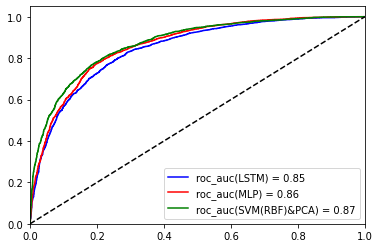

In [87]:
fpr3,tpr3,_ = roc_curve(y_test, pred_probas3) 
roc_auc3 = sklearn.metrics.auc(fpr3,tpr3) 
plt.plot(fpr3, tpr3, label = 'roc_auc(LSTM) = %.2f' % roc_auc3, color="blue") 
plt.plot(fpr2, tpr2, label = 'roc_auc(MLP) = %.2f' % roc_auc2, color="red") 
plt.plot(fpr, tpr, label = 'roc_auc(SVM(RBF)&PCA) = %.2f' % roc_auc, color="green")    # SVM above 
plt.plot([0, 1], [0, 1], 'k--') 
plt.xlim([0.0, 1.0]) 
plt.ylim([0.0, 1.05]) 
plt.legend(loc = 'lower right') 
plt.show()

In [90]:
text = "，虽然剧情有点牵强，女主设定有点奇怪，男主长的太丑了，其实还是可以一看的，期待下一部，超好看的！！！！！"
seg_list = jieba.cut(text, cut_all=False)
w2cTest = getWordVecs(list(seg_list))
shapedVector = sum(np.array(w2cTest))/len(w2cTest)
shapedVector = np.array([shapedVector]);
reshapedVector = np.reshape(shapedVector, (shapedVector.shape[0], 1, shapedVector.shape[1]))
print(LSTM_model.predict_proba(reshapedVector))

[[0.7405481]]


D:\app\anaconda\envs\pls\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


In [ ]:
model.save("outputs/MLPmodel.h5")
LSTM_model.save("outputs/LSTMmodel.h5")